# Calculating mismatches for axis-symmetric lenses

Here we calculate the mismatches with respect to different lens parameters for axially symmetric lens such as point mass and sis lens. We use the pycbc.filter package to calculate the matches. 

In [2]:
import numpy as np
import matplotlib.pyplot as pp
import pandas as pd
import heapq
import pycbc.waveform
from pycbc.types import FrequencySeries
%matplotlib inline
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
import matplotlib as mpl
import time
import multiprocessing
from joblib import Parallel, delayed
from scipy.signal import find_peaks, find_peaks_cwt
import scipy.special as sc
from scipy import interpolate

pd.set_option('display.float_format', lambda x: '%.3e' % x)
plotdirName = "/Users/saifali/Desktop/gwlensing/plots/"

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter, NullFormatter
from matplotlib.ticker import MaxNLocator
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.size'] = 25
mpl.rcParams['legend.handlelength'] = 3.0
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['xtick.minor.width'] = 1.0
mpl.rcParams['xtick.major.size'] = 5.0
mpl.rcParams['xtick.minor.size'] = 3.0
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['ytick.minor.width'] = 1.0
mpl.rcParams['ytick.major.size'] = 5.0
mpl.rcParams['ytick.minor.size'] = 3.0
mpl.rcParams['ytick.right'] = True

plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = '\\usepackage{sfmath}'


In [314]:
def unlensed_waveform(**args):
    
    theta_s = args['theta_s']
    phi_s = args['phi_s']
    theta_l = args['theta_l']
    phi_l = args['phi_l']
    mcz = args['mcz']
    dist = args['dist']
    eta = args['eta']
    tc = args['tc']
    phi_c = args['phi_c']
    flow = args['f_lower']
    
    df = args['delta_f']
    
    def limit(mcz, eta):
        low_limit = 20
        f_cut = 1 / (np.power(6, 3/2) * np.pi * ((mcz) / (np.power(eta, 3/5))))
        return low_limit, f_cut
    
    f = np.arange(flow, limit(mcz, eta)[1], df)
    #print(limit(mcz, eta)[1])
    """
    This file is just functionized form of L_unlensed(which was "object-oriented"). This was mainly created
    for the optimization of overlap function.
    """
    def mass_conv(mcz, eta):
        """Converts chirp mass to total mass. M = mcz/eta^(3/5)
        """

        M_val = mcz/np.power(eta, 3/5)
        return M_val

    def l_dot_n(theta_s, theta_l, phi_s, phi_l):
        """TODO
        """

        cos_term = np.cos(theta_s) * np.cos(theta_l)
        sin_term = np.sin(theta_s) * np.sin(theta_l) * np.cos(phi_s - phi_l)

        inner_prod = cos_term + sin_term
        return inner_prod

    def amp(mcz, dist):
        """TODO
        """

        amplitude = np.sqrt(5 / 96) * np.power(np.pi, -2 / 3) * np.power(mcz, 5 / 6) / (dist)
        return amplitude

    def psi(f, tc, phi_c, mcz, eta):
        """eqn 3.13 in Cutler-Flanaghan 1994
        """

        front_terms = 2 * np.pi * f * tc - phi_c - np.pi / 4
        main_coeffs = 0.75 * np.power(8 * np.pi * mcz * f, -5 / 3)
        main_terms = (1 + 20 / 9 * (743 / 336 + 11 / 4 * eta) * np.power(np.pi * mass_conv(mcz, eta) * f, 2 / 3)
                        - (16 * np.pi) * np.power(np.pi * mass_conv(mcz, eta) * f, 1))

        psi_val = front_terms + main_coeffs * (main_terms)
        return psi_val

    def psi_s(theta_s, theta_l, phi_s, phi_l):

        numerator = np.cos(theta_l)-np.cos(theta_s)*(l_dot_n(theta_s, theta_l, phi_s, phi_l))
        denominator = np.sin(theta_s)*np.sin(theta_l)*np.sin(phi_l-phi_s)

        psi_s_val = np.arctan2(numerator, denominator)
        return psi_s_val


    def fIp(theta_s, phi_s):
        """TODO
        """

        term_1 = (1 / 2 * (1 + np.power(np.cos(theta_s), 2)) * np.cos(2*phi_s)* np.cos(2*psi_s(theta_s, theta_l, phi_s, phi_l)))
        term_2 = (np.cos(theta_s) * np.sin(2*phi_s)* np.sin(2*psi_s(theta_s, theta_l, phi_s, phi_l)))

        fIp_val = term_1 - term_2
        return fIp_val

    def fIc(theta_s, phi_s):
        """TODO
        """

        term_1 = (1 / 2 * (1 + np.power(np.cos(theta_s), 2)) * np.cos(2*phi_s)
                    * np.sin(2*psi_s(theta_s, theta_l, phi_s, phi_l)))
        term_2 = (np.cos(theta_s) * np.sin(2*phi_s)
                    * np.cos(2*psi_s(theta_s, theta_l, phi_s, phi_l)))

        fIc_val = term_1 + term_2
        return fIc_val

    def lambdaI():
        """TODO
        """

        term_1 = np.power(2 * l_dot_n(theta_s, theta_l, phi_s, phi_l) * fIc(theta_s, phi_s), 2)
        term_2 = np.power((1 + np.power(l_dot_n(theta_s, theta_l, phi_s, phi_l), 2)) * fIp(theta_s, phi_s), 2)

        lambdaI_val = np.sqrt(term_1 + term_2)
        return lambdaI_val

    def phi_pI():
        """TODO
        """

        numerator = (2 * l_dot_n(theta_s, theta_l, phi_s, phi_l) * fIc(theta_s, phi_s))
        denominator = ((1 + np.power(l_dot_n(theta_s, theta_l, phi_s, phi_l), 2)) * fIp(theta_s, phi_s))

        phi_pI_val = np.arctan2(numerator, denominator)
        return phi_pI_val

    term_1 = lambdaI()
    term_2 = (np.exp(-1j * phi_pI()))
    term_3 = amp(mcz, dist) * np.power(f, -7 / 6)
    term_4 = np.exp(1j * psi(f, tc, phi_c, mcz, eta))

    signal_I = term_1 * term_2 * term_3 * term_4
    
    signal_I = FrequencySeries(signal_I, delta_f = df)
    return signal_I, f

In [5]:
pycbc.waveform.add_custom_waveform('unlensed', unlensed_waveform, 'frequency', force=True)

In [6]:
solar_mass = 4.92624076 * 10**-6 #[solar_mass] = sec
giga_parsec = 1.02927125 * 10**17 #[giga_parsec] = sec

hf, freq_arr = pycbc.waveform.get_fd_waveform(approximant="unlensed",
                                        theta_s = 0, phi_s = 0, theta_l = 0, phi_l = 0, 
                                        mcz = 20 * solar_mass, dist = 1 * giga_parsec, eta = 0.25,
                                        tc = 0, phi_c = 0,
                                        delta_f=1/4, f_lower = 20)


In [8]:
def Sn(f):
        """From table 1 of arXiv:0903.0338. Changed from iLIGO to aLIGO.
        """
        fs = 20
        if f < fs:
            Sn_val = np.inf
        else:
            S0 = 1E-49
            f0 = 215
            Sn_temp = np.power(f/f0, -4.14) - 5 * np.power(f/f0, -2) + 111 * ((1 - np.power(f/f0, 2) + 0.5 * np.power(f/f0, 4)) / (1 + 0.5 * np.power(f/f0, 2)))
            Sn_val = Sn_temp * S0

        return Sn_val
    
psd_analytical = np.zeros_like(freq_arr)
for i in range(len(freq_arr)):
    psd_analytical[i] = Sn(freq_arr[i])
psd_analytical = FrequencySeries(psd_analytical, delta_f = 1/4)
#pp.loglog(freq_arr, psd_analytical)

In [9]:
def magnification(y, ML, lens = 'sis'):
    
        if lens == 'pm':
            mu_plus = np.abs(0.5 + (y ** 2 + 2) / (2 * y * (y ** 2 + 4) ** 0.5))
            mu_minus = np.abs(0.5 - (y ** 2 + 2) / (2 * y * (y ** 2 + 4) ** 0.5))
        
        elif lens == 'sis':
            mu_plus = np.abs(1 + 1 / y)
            mu_minus = np.abs(-1 + 1 / y)
        
        return mu_minus / mu_plus, mu_plus, mu_minus

def time_del(y, ML, lens = 'sis'):

    if lens == 'pm':
        first_term = (y * (y ** 2 + 4) ** 0.5) / 2
        second_term = np.log(((y ** 2 + 4) ** 0.5 + y) / ((y ** 2 + 4) ** 0.5 - y))
        tds = 4 * ML * (first_term + second_term)

    elif lens == 'sis':
        tds = 8 * ML * y

    return tds
magnification(0.5, 1e4 * solar_mass, 'sis'), time_del(0.5, 1e4 * solar_mass, 'sis')

((0.3333333333333333, 3.0, 1.0), 0.19704963039999995)

In [150]:
from mpmath import *
def amp_fact_sis_wo(y, ML, f = freq_arr):
        '''computes the amplification factor for source SIS lens.
        Parameters
        ----------
        f : array
            frequency
        y : float
            source position
        Return
        ----------
        F_val : array, complex
            Amplification factor for SIS
        '''
        F_val_sis = np.zeros_like(f, dtype = np.complex128)
        for i in range(len(f)):
            w = 8 * pi * ML * f[i]
            pre_factor = exp(1j * (w / 2) * (y**2 + 2 * (y + 0.5)))
            func = lambda n: (gamma(1 + n / 2) / fac(n)) * (2 * w * exp(1j * 3 * (pi / 2))) ** (n / 2) * hyp1f1(1 + n / 2, 1, -1j * (w / 2) * y ** 2)
            series_sum = nsum(func, [0, inf])

            F_val_sis[i] = np.complex128(pre_factor * series_sum, dtype = np.complex128)

        return F_val_sis

In [11]:
def amp_fact_sis_go(y, ML, f = freq_arr):
        '''computes the amplification factor for source SIS lens in the geometrical optics limit.

        Parameters
        ----------
        f : array
            frequency

        y : float
            source position

        Return
        ----------
        F_val : array, complex
            Amplification factor for SIS
        '''
        td = time_del(y, ML)
        mu_plus = magnification(y, ML)[1]
        mu_minus = magnification(y, ML)[2]
        if y <= 1:
            F_val_sis = np.sqrt(np.abs(mu_plus)) - 1j * np.sqrt(np.abs(mu_minus)) * np.exp(2 * np.pi * 1j * f * td)
        else:
            F_val_sis = np.sqrt(np.abs(mu_plus))  
    
        return F_val_sis

In [12]:
def amp_fact_pm_wo(y, ML, f = freq_arr):
    '''computes the amplification factor for source point mass lens.

    Parameters
    ----------
    f : float
    frequency

    y : float
    source position

    Return
    ----------
    F_val : float, complex
    Amplification factor for point mass
    '''
    F_val_pm = np.zeros_like(f, dtype = np.complex128)
    for i in range(len(f)):
        w = 8 * np.pi * ML * f[i]
        x_m = 0.5 * (y + np.sqrt(y**2 + 4))
        phi_m = np.power((x_m - y) , 2) / 2 - np.log(x_m)

        first_term = np.exp(np.pi * w / 4 + 1j * (w / 2) * (np.log(w / 2) - 2 * phi_m)) 
        second_term = sc.gamma(1 - 1j * (w / 2)) 
        third_term = mp.hyp1f1(1j * w / 2, 1, 1j * (w / 2) * (y**2), maxterms = 10**6)

        F_val_pm_temp = first_term * second_term * third_term
        F_val_pm[i] = np.complex128(F_val_pm_temp, dtype = np.complex128)

    return F_val_pm

In [13]:
def amp_fact_pm_go(I, td, f = freq_arr):
    
    F_val_sis = np.zeros_like(f, dtype = np.complex128)
    for i in range(len(f)):
        F_val_sis_temp = 1 - 1j * (I ** 0.5) * np.exp(2 * np.pi * 1j * f[i] * td)
        F_val_sis[i] = np.complex128(F_val_sis_temp, dtype = np.complex128)

    return F_val_sis

In [14]:
def get_f_transition(y, ML):
        """ Calculate the frequency (f_transition) after which geometrical optics is valid
        """
        freq_range = np.logspace(np.log10(0.001), np.log10(250), 200)
        Fsis_series = np.abs(amp_fact_sis_wo(y, ML, freq_range)) 
        peaks, _ = find_peaks(Fsis_series) 
        
        return freq_range[peaks][0]
    
# f_trans = get_f_transition(0.5, 1e4 * solar_mass)
# td = time_del(0.5, 1e4 * solar_mass, 'sis')

# f_trans, td, f_trans * td

In [59]:
def pycbc_match(y, ML, hf = hf):
    
#     if ML > 3e3 * solar_mass:
#         print('using go')
#         hf_lensed_source = hf * amp_fact_sis_go(y, ML)
#     else:
#         hf_lensed_source = hf * amp_fact_sis_wo(y, ML)
    hf_lensed_source = hf * amp_fact_pm_wo(y, ML)
    pycbc_match = match(hf_lensed_source, hf, psd=psd_analytical, low_frequency_cutoff=20)[0]
    
    return pycbc_match

In [16]:
def pycbc_match_go(I, td, hf = hf):

    hf_lensed_source = hf * amp_fact_pm_go(I, td)
    pycbc_match = match(hf_lensed_source, hf, psd=psd_analytical, low_frequency_cutoff=20)[0]
    
    return pycbc_match

## Contour plot for point mass lens

In [17]:
num_pts = 60
y_range_temp = np.linspace(0.1, 1, num_pts)
ML_range_temp = np.linspace(1e1 * solar_mass, 6.5e3 * solar_mass, num_pts)
y_mesh_pm, ML_mesh_pm = np.meshgrid(y_range_temp, ML_range_temp)
y_range = y_mesh_pm.flatten()
ML_range = ML_mesh_pm.flatten()
match_range_pm = np.zeros_like(ML_range)

for i in range(y_range.shape[0]):
    match_range_pm[i] = pycbc_match(y_range[i], ML_range[i])
mismatch_mesh_pm = 1 - match_range_pm.reshape(num_pts, num_pts)

## 1D mismatch from TACC (SIS)

In [23]:
data_1d_y_0pt2 = pd.read_csv('/Users/saifali/Desktop/gwlensing/data/pycbc_1d_match_sis_ml_y_0pt2.csv', header = None, converters = {1: eval})
data_1d_y_0pt2['ML'] = np.array([data_1d_y_0pt2[1][i][1] for i in range(len(data_1d_y_0pt2))])
data_1d_y_0pt2['match'] = np.array([data_1d_y_0pt2[1][i][2] for i in range(len(data_1d_y_0pt2))])
data_1d_y_0pt2 = data_1d_y_0pt2.sort_values(by = 0)

data_1d_y_0pt6 = pd.read_csv('/Users/saifali/Desktop/gwlensing/data/pycbc_1d_match_sis_ml_y_0pt6.csv', header = None, converters = {1: eval})
data_1d_y_0pt6['ML'] = np.array([data_1d_y_0pt6[1][i][1] for i in range(len(data_1d_y_0pt6))])
data_1d_y_0pt6['match'] = np.array([data_1d_y_0pt6[1][i][2] for i in range(len(data_1d_y_0pt6))])
data_1d_y_0pt6 = data_1d_y_0pt6.sort_values(by = 0)

data_1d_y_1pt0 = pd.read_csv('/Users/saifali/Desktop/gwlensing/data/pycbc_1d_match_sis_ml_y_1pt0.csv', header = None, converters = {1: eval})
data_1d_y_1pt0['ML'] = np.array([data_1d_y_1pt0[1][i][1] for i in range(len(data_1d_y_1pt0))])
data_1d_y_1pt0['match'] = np.array([data_1d_y_1pt0[1][i][2] for i in range(len(data_1d_y_1pt0))])
data_1d_y_1pt0 = data_1d_y_1pt0.sort_values(by = 0)

####################################################################################################################################

data_1d_ml_2e3 = pd.read_csv('/Users/saifali/Desktop/gwlensing/data/pycbc_1d_match_sis_y_ml_2e3.csv', header = None, converters = {1: eval})
data_1d_ml_2e3['y'] = np.array([data_1d_ml_2e3[1][i][0] for i in range(len(data_1d_ml_2e3))])
data_1d_ml_2e3['match'] = np.array([data_1d_ml_2e3[1][i][2] for i in range(len(data_1d_ml_2e3))])
data_1d_ml_2e3 = data_1d_ml_2e3.sort_values(by = 0)

data_1d_ml_4e3 = pd.read_csv('/Users/saifali/Desktop/gwlensing/data/pycbc_1d_match_sis_y_ml_4e3.csv', header = None, converters = {1: eval})
data_1d_ml_4e3['y'] = np.array([data_1d_ml_4e3[1][i][0] for i in range(len(data_1d_ml_4e3))])
data_1d_ml_4e3['match'] = np.array([data_1d_ml_4e3[1][i][2] for i in range(len(data_1d_ml_4e3))])
data_1d_ml_4e3 = data_1d_ml_4e3.sort_values(by = 0)

data_1d_ml_6e3 = pd.read_csv('/Users/saifali/Desktop/gwlensing/data/pycbc_1d_match_sis_y_ml_6e3.csv', header = None, converters = {1: eval})
data_1d_ml_6e3['y'] = np.array([data_1d_ml_6e3[1][i][0] for i in range(len(data_1d_ml_6e3))])
data_1d_ml_6e3['match'] = np.array([data_1d_ml_6e3[1][i][2] for i in range(len(data_1d_ml_6e3))])
data_1d_ml_6e3 = data_1d_ml_6e3.sort_values(by = 0)

####################################################################################################################################


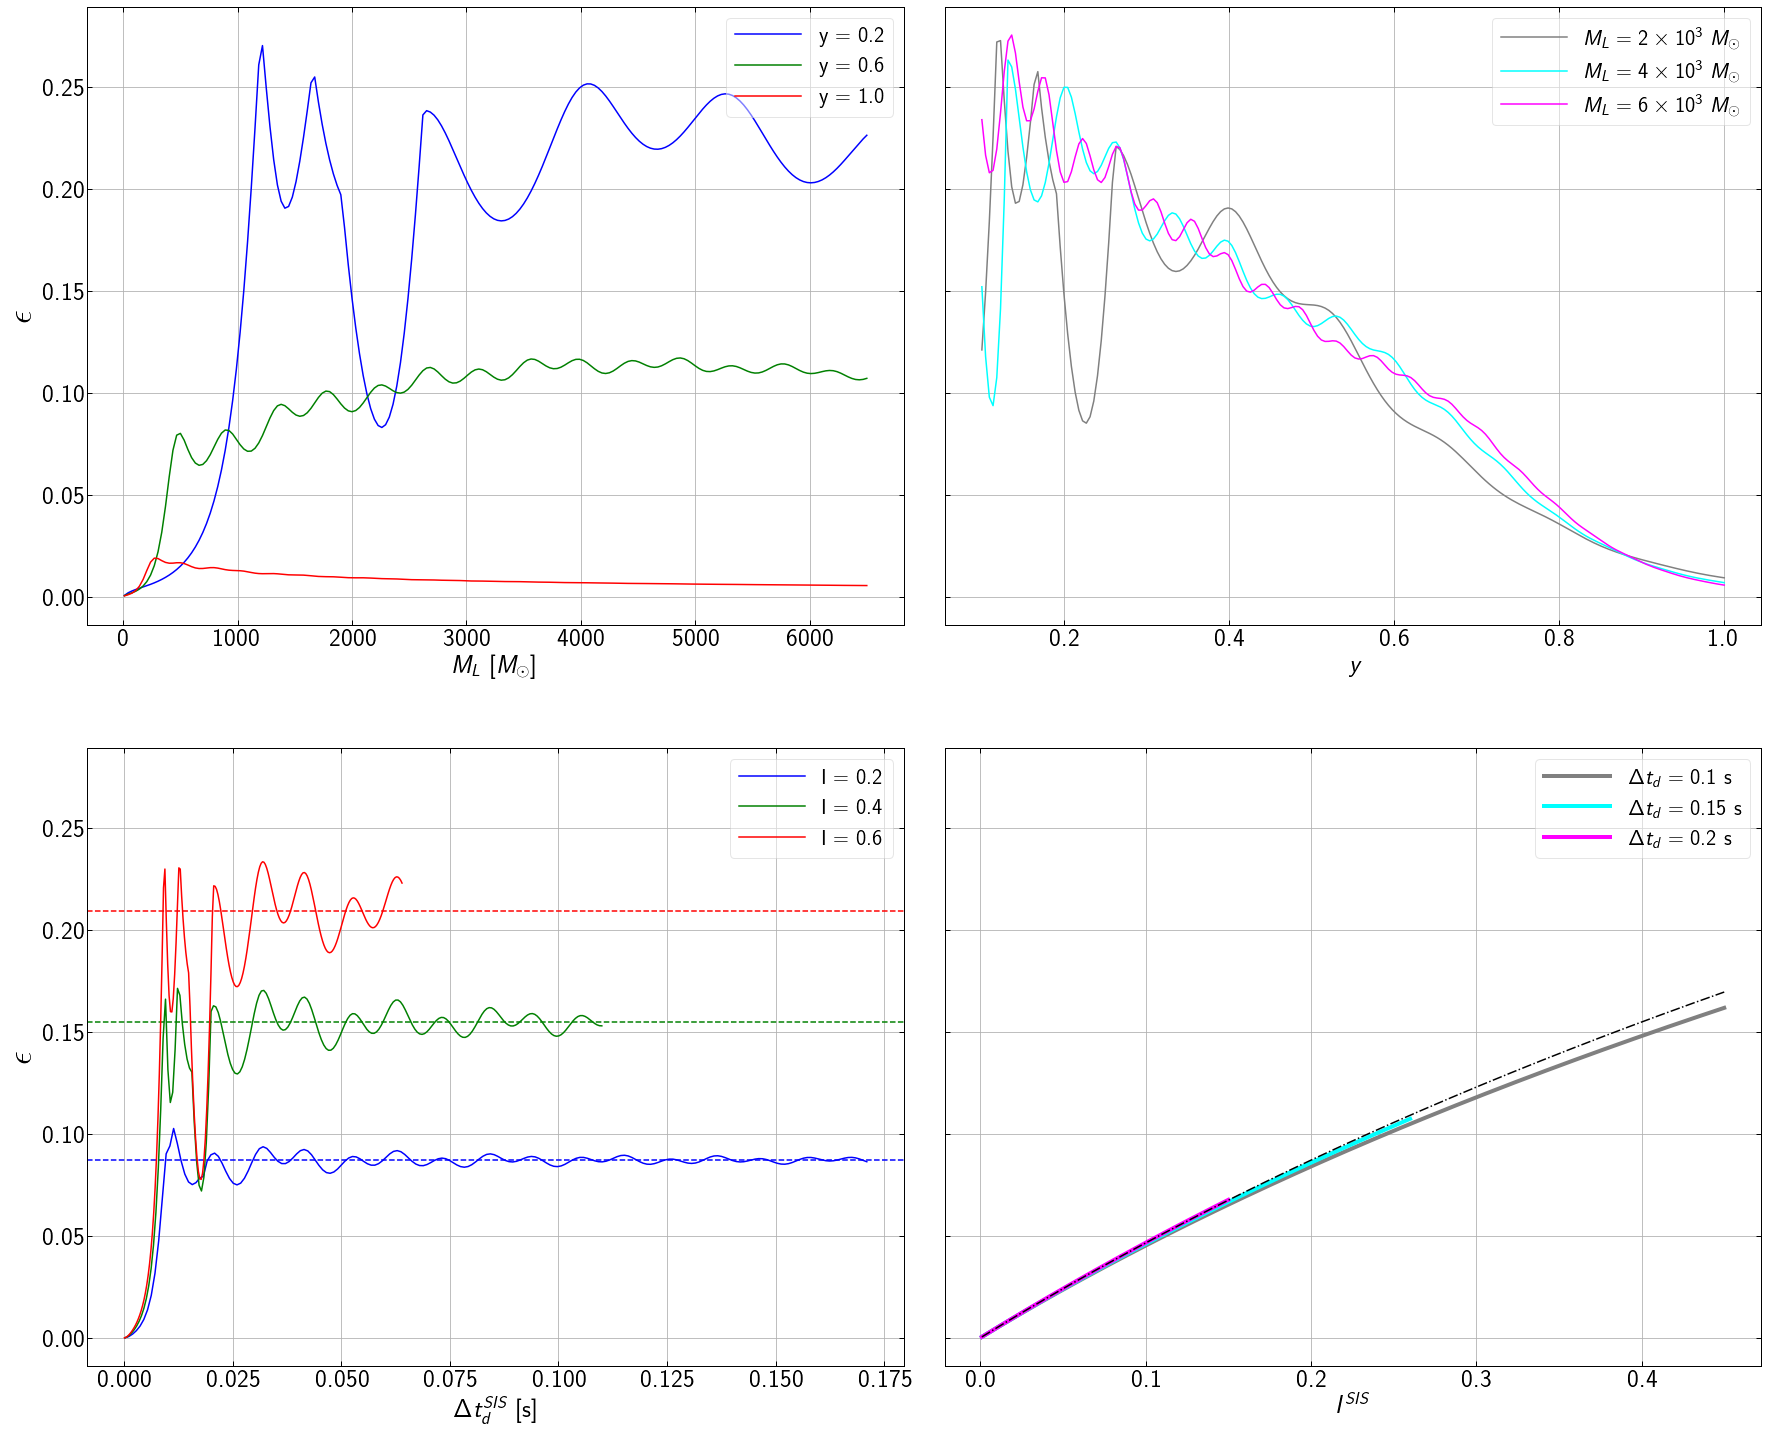

In [48]:
data_1d_I_0pt2 = pd.read_csv('/Users/saifali/Desktop/gwlensing/data/pycbc_1d_match_sis_ml_fluxratio_0pt2.csv', header = None, converters = {1: eval})
data_1d_I_0pt2['td'] = np.array([data_1d_I_0pt2[1][i][1] for i in range(len(data_1d_I_0pt2))])
data_1d_I_0pt2['match'] = np.array([data_1d_I_0pt2[1][i][2] for i in range(len(data_1d_I_0pt2))])
data_1d_I_0pt2 = data_1d_I_0pt2.sort_values(by = 0)

data_1d_I_0pt4 = pd.read_csv('/Users/saifali/Desktop/gwlensing/data/pycbc_1d_match_sis_ml_fluxratio_0pt4.csv', header = None, converters = {1: eval})
data_1d_I_0pt4['td'] = np.array([data_1d_I_0pt4[1][i][1] for i in range(len(data_1d_I_0pt4))])
data_1d_I_0pt4['match'] = np.array([data_1d_I_0pt4[1][i][2] for i in range(len(data_1d_I_0pt4))])
data_1d_I_0pt4 = data_1d_I_0pt4.sort_values(by = 0)

data_1d_I_0pt6 = pd.read_csv('/Users/saifali/Desktop/gwlensing/data/pycbc_1d_match_sis_ml_fluxratio_0pt6.csv', header = None, converters = {1: eval})
data_1d_I_0pt6['td'] = np.array([data_1d_I_0pt6[1][i][1] for i in range(len(data_1d_I_0pt6))])
data_1d_I_0pt6['match'] = np.array([data_1d_I_0pt6[1][i][2] for i in range(len(data_1d_I_0pt6))])
data_1d_I_0pt6 = data_1d_I_0pt6.sort_values(by = 0)

####################################################################################################################################

data_1d_td_0pt1 = pd.read_csv('/Users/saifali/Desktop/gwlensing/data/pycbc_1d_match_sis_ml_timedel_0pt1.csv', header = None, converters = {1: eval})
data_1d_td_0pt1['I'] = np.array([data_1d_td_0pt1[1][i][0] for i in range(len(data_1d_td_0pt1))])
data_1d_td_0pt1['match'] = np.array([data_1d_td_0pt1[1][i][2] for i in range(len(data_1d_td_0pt1))])
data_1d_td_0pt1 = data_1d_td_0pt1.sort_values(by = 0)

data_1d_td_0pt15 = pd.read_csv('/Users/saifali/Desktop/gwlensing/data/pycbc_1d_match_sis_ml_timedel_0pt15.csv', header = None, converters = {1: eval})
data_1d_td_0pt15['I'] = np.array([data_1d_td_0pt15[1][i][0] for i in range(len(data_1d_td_0pt15))])
data_1d_td_0pt15['match'] = np.array([data_1d_td_0pt15[1][i][2] for i in range(len(data_1d_td_0pt15))])
data_1d_td_0pt15 = data_1d_td_0pt15.sort_values(by = 0)

data_1d_td_0pt2 = pd.read_csv('/Users/saifali/Desktop/gwlensing/data/pycbc_1d_match_sis_ml_timedel_0pt2.csv', header = None, converters = {1: eval})
data_1d_td_0pt2['I'] = np.array([data_1d_td_0pt2[1][i][0] for i in range(len(data_1d_td_0pt2))])
data_1d_td_0pt2['match'] = np.array([data_1d_td_0pt2[1][i][2] for i in range(len(data_1d_td_0pt2))])
data_1d_td_0pt2 = data_1d_td_0pt2.sort_values(by = 0)

####################################################################################################################################

fig, axs = plt.subplots(2, 2, figsize = (30, 25), sharey = True, gridspec_kw={'wspace': .05})

axs[0, 0].plot(data_1d_y_0pt2['ML'] / solar_mass, 1 - data_1d_y_0pt2['match'], label = 'y = 0.2', color = 'blue')
axs[0, 0].plot(data_1d_y_0pt6['ML'] / solar_mass, 1 - data_1d_y_0pt6['match'], label = 'y = 0.6', color = 'green')
axs[0, 0].plot(data_1d_y_1pt0['ML'] / solar_mass, 1 - data_1d_y_1pt0['match'], label = 'y = 1.0', color = 'red')
axs[0, 0].tick_params(axis='both', which='major', labelsize=25)
axs[0, 0].set_xlabel(r'$M_L$ $[M_\odot]$', fontsize = 25)
axs[0, 0].set_ylabel(r'$\epsilon$', fontsize = 35)
axs[0, 0].grid()

axs[0, 1].plot(data_1d_ml_2e3['y'], 1 - data_1d_ml_2e3['match'], label = r'$M_L = 2 \times 10^3$ $M_\odot$', color = 'gray')
axs[0, 1].plot(data_1d_ml_4e3['y'], 1 - data_1d_ml_4e3['match'], label = r'$M_L = 4 \times 10^3$ $M_\odot$', color = 'cyan')
axs[0, 1].plot(data_1d_ml_6e3['y'], 1 - data_1d_ml_6e3['match'], label = r'$M_L = 6 \times 10^3$ $M_\odot$', color = 'magenta')
axs[0, 1].tick_params(axis='both', which='major', labelsize=25)
axs[0, 1].set_xlabel(r'$y$', fontsize = 25)
#ax2.set_ylabel(r'$\epsilon$', fontsize = 35)
axs[0, 1].grid()

# fig.legend(ncol=2,loc='lower center', bbox_to_anchor=(0.5,.9), fontsize=20, framealpha=0.5)
#plt.savefig('1D_plot_mismatch_ML.pdf', dpi = 500, bbox_inches = 'tight')

####################################################################################################################################

def mismatch_go(I):
    mismatch = 1 - 1 / np.sqrt(1 + I)
    return mismatch

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 8), sharey = True, gridspec_kw={'wspace': .05})

axs[1, 0].plot(data_1d_I_0pt2['td'], 1 - data_1d_I_0pt2['match'], label = 'I = 0.2', color = 'blue')
axs[1, 0].axhline(y = mismatch_go(0.2), ls = '--', color = 'blue')
axs[1, 0].plot(data_1d_I_0pt4['td'], 1 - data_1d_I_0pt4['match'], label = 'I = 0.4', color = 'green')
axs[1, 0].axhline(y = mismatch_go(0.4), ls = '--', color = 'green')
axs[1, 0].plot(data_1d_I_0pt6['td'], 1 - data_1d_I_0pt6['match'], label = 'I = 0.6', color = 'red')
axs[1, 0].axhline(y = mismatch_go(0.6), ls = '--', color = 'red')
axs[1, 0].tick_params(axis='both', which='major', labelsize=25)
axs[1, 0].set_xlabel(r'$\Delta t_d^{SIS}$ [s]', fontsize = 25)
axs[1, 0].set_ylabel(r'$\epsilon$', fontsize = 35)
axs[1, 0].grid()

axs[1, 1].plot(data_1d_td_0pt1['I'], 1 - data_1d_td_0pt1['match'], label = r'$\Delta t_d = 0.1$ s', color = 'gray', lw = 4)
axs[1, 1].plot(data_1d_td_0pt15['I'], 1 - data_1d_td_0pt15['match'], label = r'$\Delta t_d = 0.15$ s', color = 'cyan', lw = 4)
axs[1, 1].plot(data_1d_td_0pt2['I'], 1 - data_1d_td_0pt2['match'], label = r'$\Delta t_d = 0.2$ s', color = 'magenta', lw = 4)
axs[1, 1].plot(data_1d_td_0pt1['I'], mismatch_go(np.array(data_1d_td_0pt1['I'])), color = 'black', ls = '-.')
axs[1, 1].tick_params(axis='both', which='major', labelsize=25)
axs[1, 1].set_xlabel(r'$I^{SIS}$', fontsize = 25)
#ax2.set_ylabel(r'$\epsilon$', fontsize = 35)
axs[1, 1].grid()

axs[0, 0].legend(fontsize=22, loc = 'upper right', framealpha = 0.5)
axs[0, 1].legend(fontsize=22, loc = 'upper right', framealpha = 0.5)
axs[1, 0].legend(fontsize=22, loc = 'upper right', framealpha = 0.5)
axs[1, 1].legend(fontsize=22, loc = 'upper right', framealpha = 0.5)
# plt.savefig(plotdirName + '1D_plot_mismatch_combo.pdf', dpi = 500, bbox_inches = 'tight')

## From TACC for SIS lens

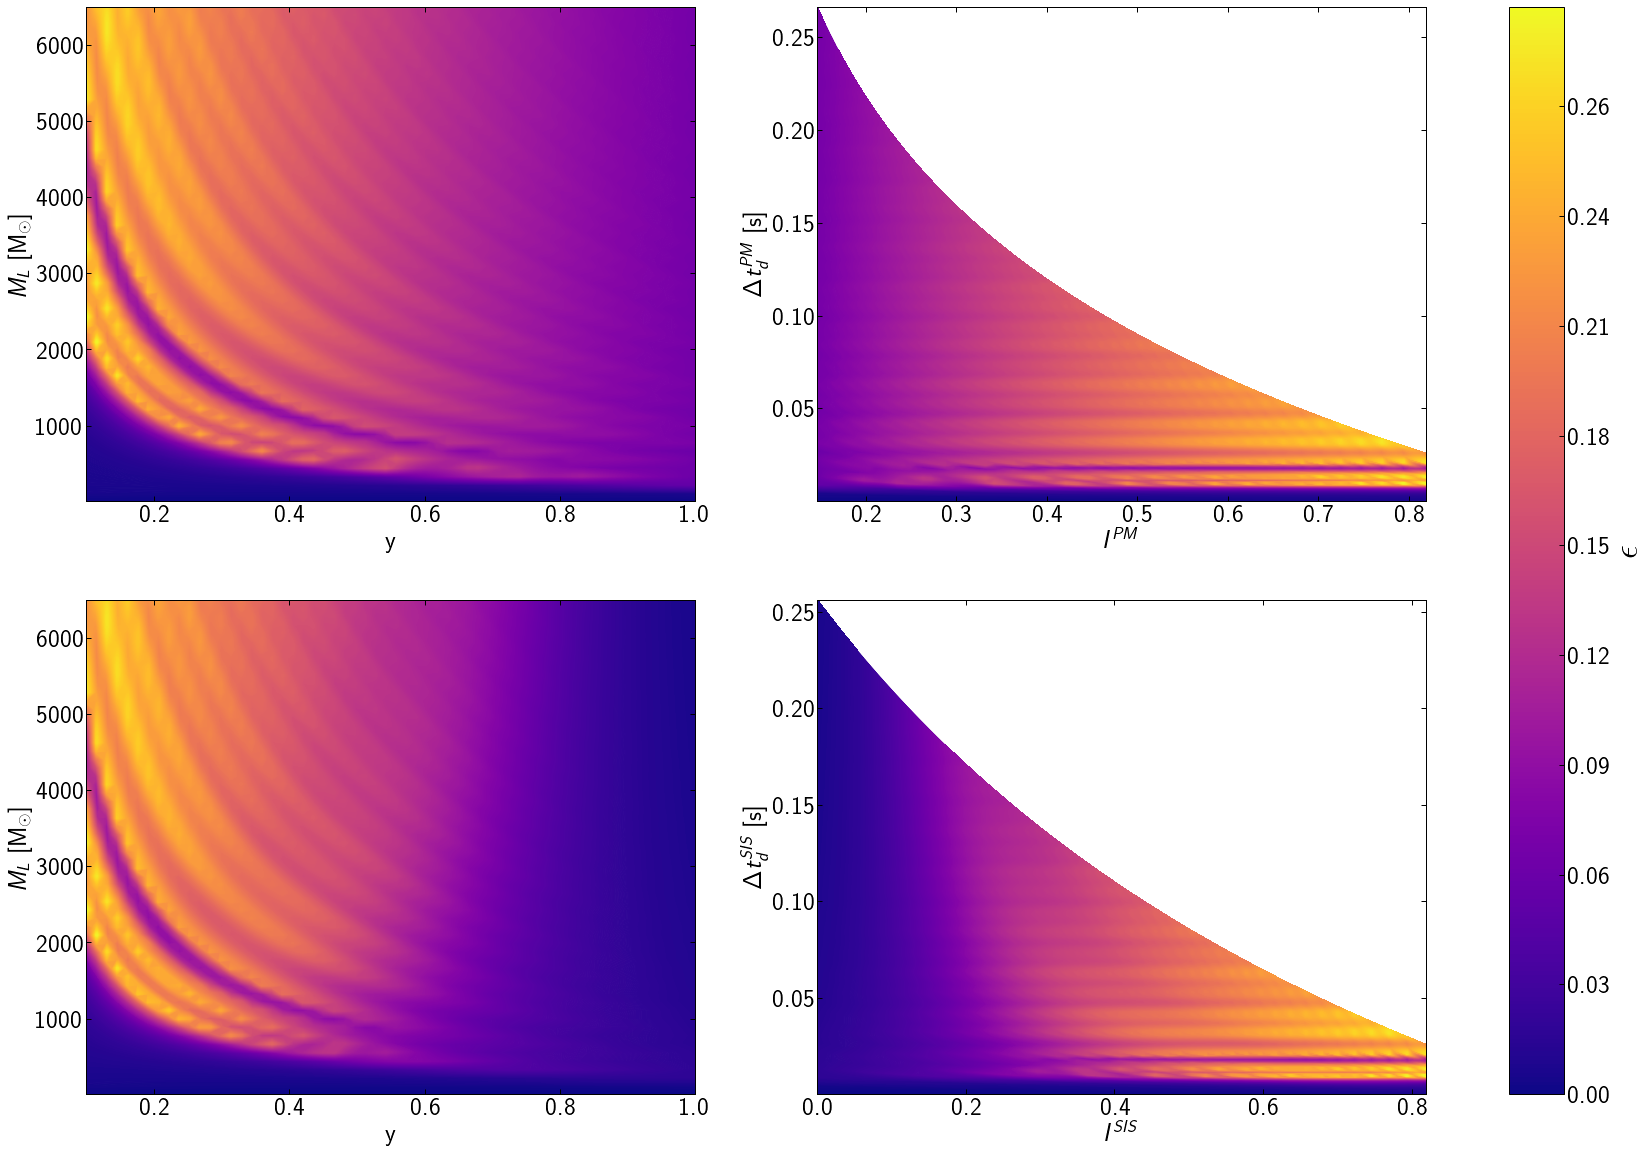

In [42]:
I_mesh_pm = magnification(y_mesh_pm, ML_mesh_pm, lens = 'pm')[0]
td_mesh_pm = time_del(y_mesh_pm, ML_mesh_pm, lens = 'pm')

data_tacc = pd.read_csv('/Users/saifali/Desktop/gwlensing/data/pycbc_match_sis_3600pts.csv', header = None, converters = {1: eval})
data_tacc['y'] = np.array([data_tacc[1][i][0] for i in range(len(data_tacc))])
data_tacc['ML'] = np.array([data_tacc[1][i][1] for i in range(len(data_tacc))])
data_tacc['match'] = np.array([data_tacc[1][i][2] for i in range(len(data_tacc))])
data_tacc = data_tacc.sort_values(by = 0)

y_mesh_sis = np.array(data_tacc['y']).reshape(num_pts, num_pts)
ML_mesh_sis = np.array(data_tacc['ML']).reshape(num_pts, num_pts)
match_mesh_sis = np.array(data_tacc['match']).reshape(num_pts, num_pts)
mismatch_mesh_sis = 1 - match_mesh_sis

I_mesh_sis = magnification(y_mesh_pm.ravel(), ML_mesh_pm.ravel())[0].reshape(num_pts, num_pts)
td_mesh_sis = time_del(y_mesh_pm.ravel(), ML_mesh_pm.ravel()).reshape(num_pts, num_pts)

fig,ax = plt.subplots(2, 2, figsize = (30, 20))


cp1 = ax[0, 0].contourf(y_mesh_pm, ML_mesh_pm / solar_mass, mismatch_mesh_pm, levels = 1000, cmap = 'plasma')
cp2 = ax[0, 1].contourf(I_mesh_pm, td_mesh_pm, mismatch_mesh_pm, levels = 1000, cmap = 'plasma')

ax[0, 0].set_xlabel('y', fontsize = 25)
ax[0, 0].set_ylabel(r'$M_L$ $[\mathrm{M}_\odot]$', fontsize = 25)
ax[0, 0].tick_params(axis='both', which='both', direction='in', labelsize=25)

ax[0, 1].set_xlabel(r'$I^{PM}$', fontsize = 25)
ax[0, 1].set_ylabel(r'$\Delta t_d^{PM}$ [s]', fontsize = 25)
ax[0, 1].tick_params(axis='both', which='both', direction='in', labelsize=25)


cp3 = ax[1, 0].contourf(y_mesh_sis, ML_mesh_sis / solar_mass, mismatch_mesh_sis, levels = 1000, cmap = 'plasma')
cp4 = ax[1, 1].contourf(I_mesh_sis, td_mesh_sis, mismatch_mesh_sis, levels = 1000, cmap = 'plasma')

ax[1, 0].set_xlabel('y', fontsize = 25)
ax[1, 0].set_ylabel(r'$M_L$ $[\mathrm{M}_\odot]$', fontsize = 25)
ax[1, 0].tick_params(axis='both', which='both', direction='in', labelsize=25)

ax[1, 1].set_xlabel(r'$I^{SIS}$', fontsize = 25)
ax[1, 1].set_ylabel(r'$\Delta t_d^{SIS}$ [s]', fontsize = 25)
ax[1, 1].tick_params(axis='both', which='both', direction='in', labelsize=25)


cbar = fig.colorbar(cp4, ax=ax.ravel().tolist())
cbar.set_label(r'$\epsilon$', fontsize=35)
cbar.ax.tick_params(direction='in',labelsize=25)
import matplotlib.ticker as tick
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))

# for c in cp1.collections:
#     c.set_edgecolor("face")
# for c in cp2.collections:
#     c.set_edgecolor("face")
# for c in cp3.collections:
#     c.set_edgecolor("face")
# for c in cp4.collections:
#     c.set_edgecolor("face")

# plt.savefig('contour_plot_subplot_lensparam_combo.pdf', dpi = 500, bbox_inches = 'tight')

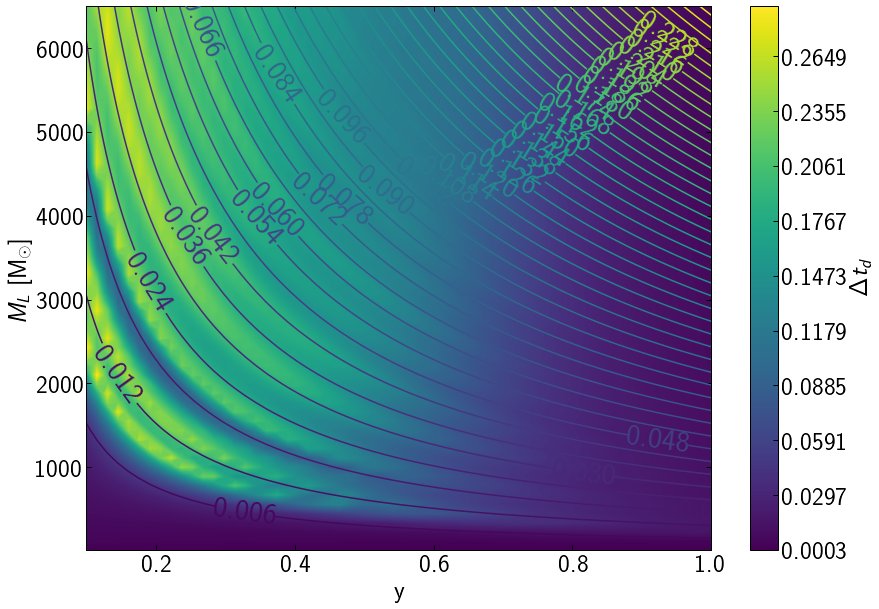

In [32]:
dat_pts = 60
y_arr = np.linspace(0.1, 1, dat_pts)
ML_arr = np.linspace(1e1 * solar_mass, 6.5e3 * solar_mass, dat_pts)
y_mesh, ML_mesh = np.meshgrid(y_arr, ML_arr)
del_td_mesh = time_del(y_mesh, ML_mesh)

y_arr = y_mesh.flatten()
ML_arr = ML_mesh.flatten()
del_td_arr = del_td_mesh.flatten()

y_mesh = y_arr.reshape(dat_pts, dat_pts)
ML_mesh = ML_arr.reshape(dat_pts, dat_pts)
del_td_mesh = del_td_arr.reshape(dat_pts, dat_pts)

fig,ax=plt.subplots(1,1, figsize = (14, 10))
ctd = plt.contour(y_mesh, ML_mesh / solar_mass, del_td_mesh, levels = 45)
cp = plt.contourf(y_mesh, ML_mesh / solar_mass, mismatch_mesh_sis, levels = 1000)
ax.set_xlabel('y', fontsize = 25)
ax.set_ylabel(r'$M_L$ $[\mathrm{M}_\odot]$', fontsize = 25)
ax.tick_params(axis='both', which='both', direction='in', labelsize=25)

plt.clabel(ctd, inline=True, fontsize=30)
cbar = fig.colorbar(cp)
cbar.set_label(r'$\Delta t_d$', fontsize=25)
cbar.ax.tick_params(direction='in',labelsize=25)

## Analysis of the 'big' dip

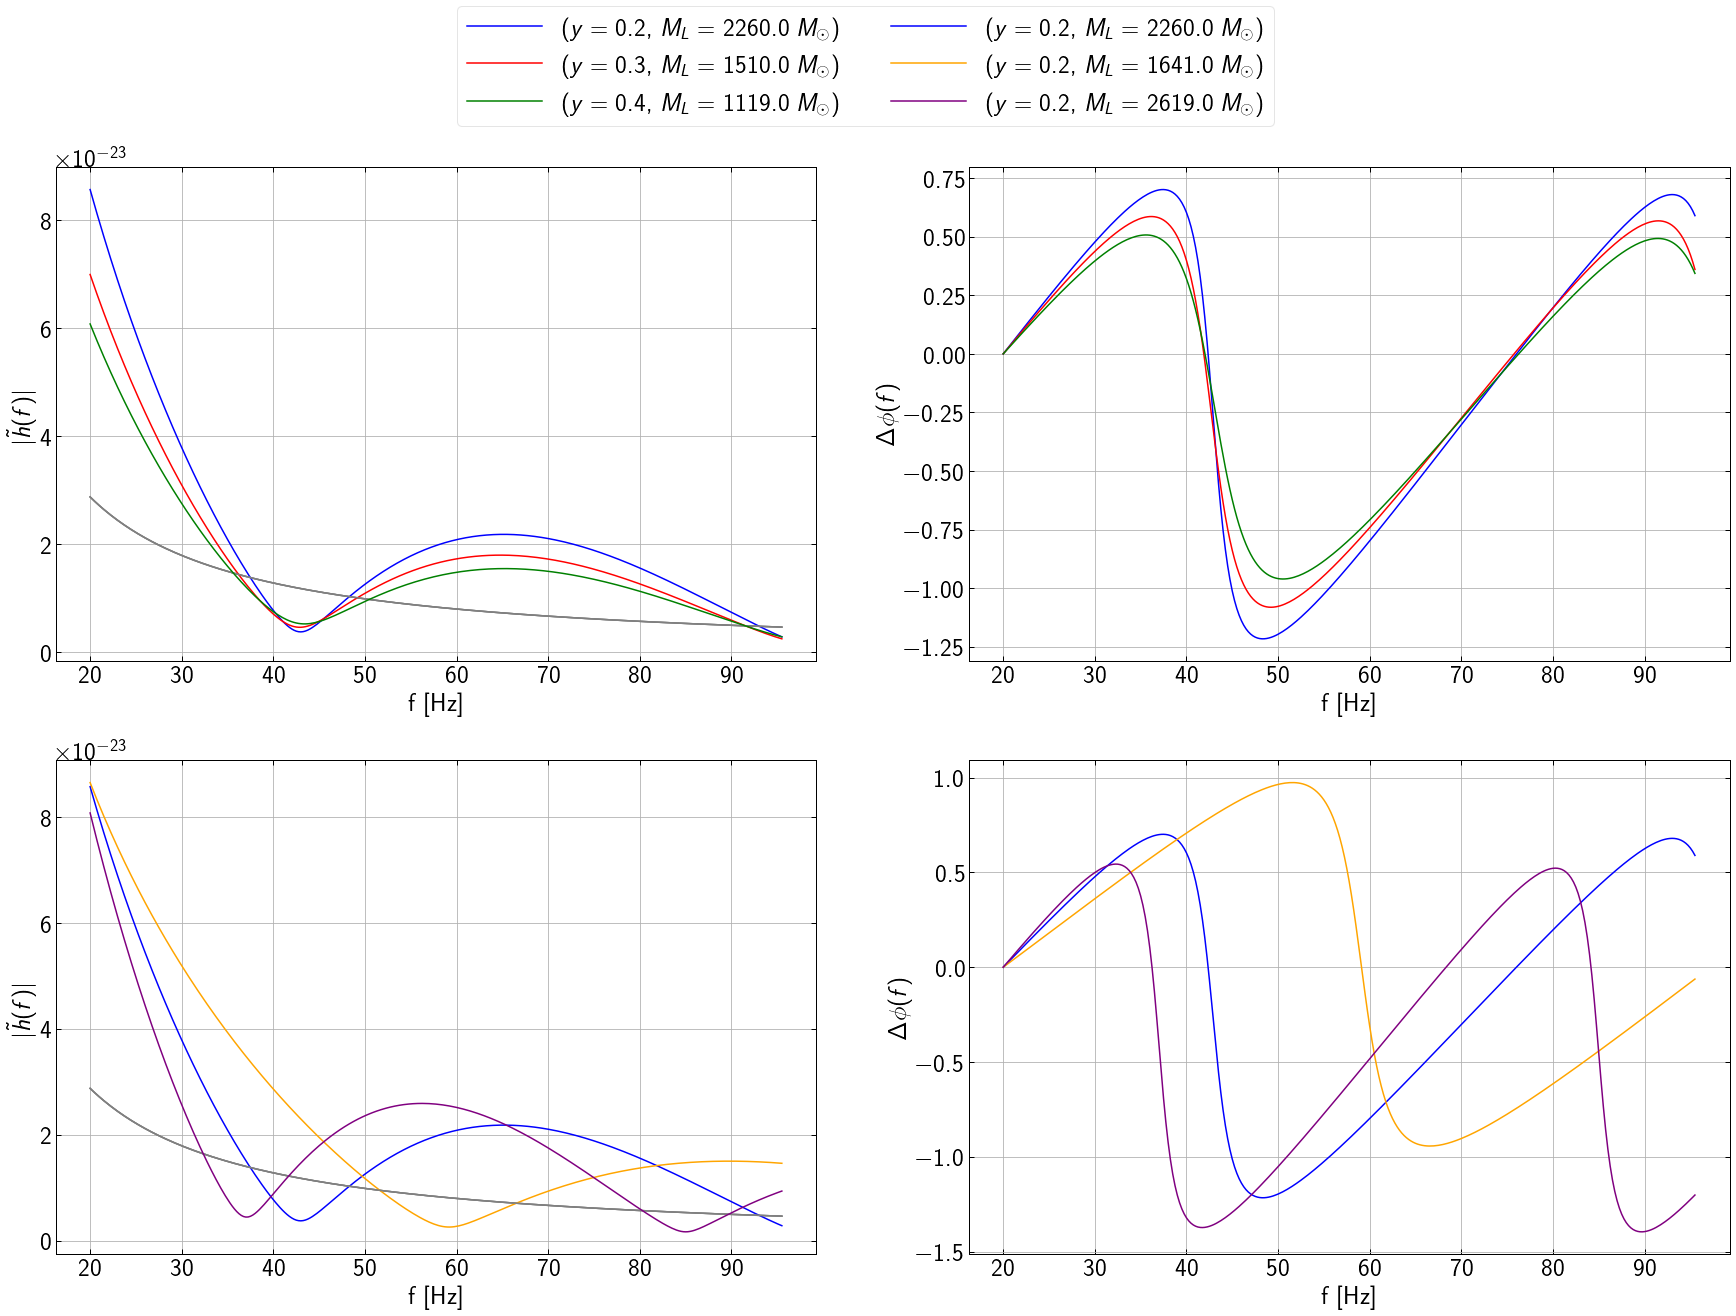

In [360]:
from pycbc.waveform.utils import phase_from_frequencyseries

color_amp_1 = ['blue', 'red', 'green']
y_list = [0.2, 0.3, 0.4] 
ML_list_1 = [2260 * solar_mass, 1510 * solar_mass, 1119 * solar_mass]

fig, axs = plt.subplots(2, 2, figsize = (30, 20))
for i in range(len(ML_list_1)):
    
    hf_lensed = hf * amp_fact_pm_wo(y_list[i], ML_list_1[i])
    axs[0, 0].plot(freq_arr, np.abs(hf), c = 'gray')
    axs[0, 0].plot(freq_arr, np.abs(hf_lensed), label = rf'($y = {y_list[i]}$, $M_L$ = {ML_list_1[i] / solar_mass:.1f} $M_\odot$)', c = color_amp_1[i])
    axs[0, 0].tick_params(axis='both', which='major', labelsize=25)
    axs[0, 0].set_xlabel('f [Hz]', fontsize = 25)
    axs[0, 0].set_ylabel(r'$|\tilde{h}(f)|$', fontsize = 25)
    axs[0, 0].grid()
    axs[0, 0].yaxis.get_offset_text().set_fontsize(25)
    
    hf_lensed = hf * amp_fact_pm_wo(y_list[i], ML_list_1[i])
    phase_lensed = phase_from_frequencyseries(hf_lensed)
    phase = phase_from_frequencyseries(hf)
    phase_diff = phase_lensed - phase
    axs[0, 1].plot(freq_arr, phase_diff, c = color_amp_1[i])
    axs[0, 1].tick_params(axis='both', which='major', labelsize=25)
    axs[0, 1].set_xlabel('f [Hz]', fontsize = 25)
    axs[0, 1].set_ylabel(r'$\Delta \phi (f)$', fontsize = 25)
    axs[0, 1].grid()
    axs[0, 1].yaxis.get_offset_text().set_fontsize(25)
    
color_amp_2 = ['blue', 'orange', 'purple']    
ML_list_2 = [2260 * solar_mass, 1641 * solar_mass, 2619 * solar_mass]
for i in range(len(ML_list_2)):
    hf_lensed = hf * amp_fact_pm_wo(y_list[0], ML_list_2[i])
    axs[1, 0].plot(freq_arr, np.abs(hf), c = 'gray')
    axs[1, 0].plot(freq_arr, np.abs(hf_lensed), label = rf'$(y = {y_list[0]}$, $M_L$ = {ML_list_2[i] / solar_mass:.1f} $M_\odot$)', c = color_amp_2[i])
    axs[1, 0].tick_params(axis='both', which='major', labelsize=25)
    axs[1, 0].set_xlabel('f [Hz]', fontsize = 25)
    axs[1, 0].set_ylabel(r'$|\tilde{h}(f)|$', fontsize = 25)
    axs[1, 0].grid()
    axs[1, 0].yaxis.get_offset_text().set_fontsize(25)
    
    hf_lensed = hf * amp_fact_pm_wo(y_list[0], ML_list_2[i])
    phase_lensed = phase_from_frequencyseries(hf_lensed)
    phase = phase_from_frequencyseries(hf)
    phase_diff = phase_lensed - phase
    axs[1, 1].plot(freq_arr, phase_diff, c = color_amp_2[i])
    axs[1, 1].tick_params(axis='both', which='major', labelsize=25)
    axs[1, 1].set_xlabel('f [Hz]', fontsize = 25)
    axs[1, 1].set_ylabel(r'$\Delta \phi (f)$', fontsize = 25)
    axs[1, 1].grid()
    axs[1, 1].yaxis.get_offset_text().set_fontsize(25)

    
fig.legend(ncol=2,loc='lower center',bbox_to_anchor=(0.5,.9),fontsize=25,framealpha=0.5)
# plt.savefig(plotdirName + 'big_dip_amp_phase_combo.pdf', dpi = 500, bbox_inches = 'tight')

In [269]:
file = '/Users/saifali/Desktop/gwlensing/data/pycbc_1d_match_pm_y_0pt2.csv'
data_1d_y_0pt2 = pd.read_csv(str(file), header = None, converters = {1: eval})
data_1d_y_0pt2['ML'] = np.array([data_1d_y_0pt2[1][i][1] for i in range(len(data_1d_y_0pt2))]) / solar_mass
data_1d_y_0pt2['match'] = np.array([data_1d_y_0pt2[1][i][2] for i in range(len(data_1d_y_0pt2))])
data_1d_y_0pt2['phase'] = np.array([data_1d_y_0pt2[1][i][4] for i in range(len(data_1d_y_0pt2))])
data_1d_y_0pt2 = data_1d_y_0pt2.sort_values(by = 0)
ML_val = 1647
idx = (data_1d_y_0pt2['ML'] - ML_val).abs().idxmin()
data_1d_y_0pt2.loc[[idx]]

,0,1,ML,match,phase
49,50,"[0.2, 0.00808225299363015, 0.749448562478508, ...",1.641e+03,7.494e-01,-2.061e+00


In [270]:
from scipy import integrate
import time

def bigdip_analysis_def_1(t_c_temp, 
                        phi_c_temp,
                        y_val,
                        ML_val):
    
    solar_mass = 4.92624076 * 10**-6 #[solar_mass] = sec
    giga_parsec = 1.02927125 * 10**17 #[giga_parsec] = sec
    
    hf, freq_arr = pycbc.waveform.get_fd_waveform(approximant="unlensed",
                                            theta_s = 0, phi_s = 0, theta_l = 0, phi_l = 0, 
                                            mcz = 20 * solar_mass, dist = 1 * giga_parsec, eta = 0.25,
                                            tc = 0, phi_c = 0,
                                            delta_f=1/4, f_lower = 20)
    
    hf_lensed = hf * amp_fact_pm_wo(y_val, ML_val)
    hf_template, freq_arr = pycbc.waveform.get_fd_waveform(approximant="unlensed",
                                            theta_s = 0, phi_s = 0, theta_l = 0, phi_l = 0, 
                                            mcz = 20 * solar_mass, dist = 1 * giga_parsec, eta = 0.25,
                                            tc = t_c_temp, phi_c = phi_c_temp,
                                            delta_f=1/4, f_lower = 20)
    
    integrand = np.conjugate(hf_template) * hf_lensed / psd_analytical
    integration = integrate.simps(integrand, freq_arr)
    return 4 * np.abs(integration)

In [250]:
t_c_temp = np.linspace(-0.2, 0.2, 500)
integ = np.zeros_like(t_c_temp)

for i in range(integ.shape[0]):
    integ[i] = bigdip_analysis_def_1(t_c_temp[i], phi_c_temp[0], y_arr[0], ML_arr[0])

In [251]:
t_c_temp[np.argmax(integ)]

0.002004008016032066

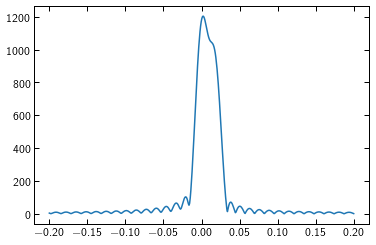

In [252]:
plt.plot(t_c_temp, integ)

In [361]:
y_arr = [0.2, 0.3, 0.4]
ML_arr = [2260 * solar_mass, 1510 * solar_mass, 1119 * solar_mass]
phi_c_temp = [2.066, 2.054, 2.076]
max_tc = [0.002004, 0.002004, 0.001202]

ML_arr_2 = [2260 * solar_mass, 1641 * solar_mass, 2619 * solar_mass]
phi_c_temp_2 = [2.066, -2.061, -4.06e-3]
max_tc_2 = [0.002004, -0.002805, 0.0004]

from pycbc.waveform.utils import phase_from_frequencyseries

def bigdip_analysis_def_2(t_c_val, 
                        phi_c_val,
                        y_val,
                        ML_val):
    
    solar_mass = 4.92624076 * 10**-6 #[solar_mass] = sec
    giga_parsec = 1.02927125 * 10**17 #[giga_parsec] = sec
    
    hf, freq_arr = pycbc.waveform.get_fd_waveform(approximant="unlensed",
                                            theta_s = 0, phi_s = 0, theta_l = 0, phi_l = 0, 
                                            mcz = 20 * solar_mass, dist = 1 * giga_parsec, eta = 0.25,
                                            tc = 0, phi_c = 0,
                                            delta_f=1/4, f_lower = 20)
    
    hf_lensed = hf * amp_fact_pm_wo(y_val, ML_val)
    hf_template, freq_arr = pycbc.waveform.get_fd_waveform(approximant="unlensed",
                                            theta_s = 0, phi_s = 0, theta_l = 0, phi_l = 0, 
                                            mcz = 20 * solar_mass, dist = 1 * giga_parsec, eta = 0.25,
                                            tc = t_c_val, phi_c = phi_c_val,
                                            delta_f=1/4, f_lower = 20)
    
    phase_lensed = phase_from_frequencyseries(hf_lensed)
    phase = phase_from_frequencyseries(hf)
    
    return phase_lensed - phase

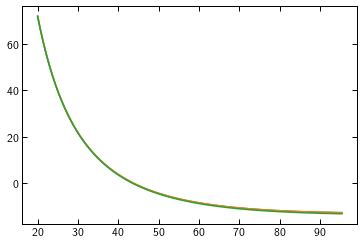

In [377]:
def mass_conv(mcz, eta):
        """Converts chirp mass to total mass. M = mcz/eta^(3/5)
        """

        M_val = mcz/np.power(eta, 3/5)
        return M_val
    
def psi(f, tc, phi_c, mcz, eta):
        """eqn 3.13 in Cutler-Flanaghan 1994
        """

        front_terms = 2 * np.pi * f * tc - phi_c - np.pi / 4
        main_coeffs = 0.75 * np.power(8 * np.pi * mcz * f, -5 / 3)
        main_terms = (1 + 20 / 9 * (743 / 336 + 11 / 4 * eta) * np.power(np.pi * mass_conv(mcz, eta) * f, 2 / 3)
                        - (16 * np.pi) * np.power(np.pi * mass_conv(mcz, eta) * f, 1))

        psi_val = front_terms + main_coeffs * (main_terms)
        return psi_val


for i in range(len(max_tc)):
    plt.plot(freq_arr, psi(freq_arr, max_tc[i], phi_c_temp[i], 20 * solar_mass, eta = 0.25))

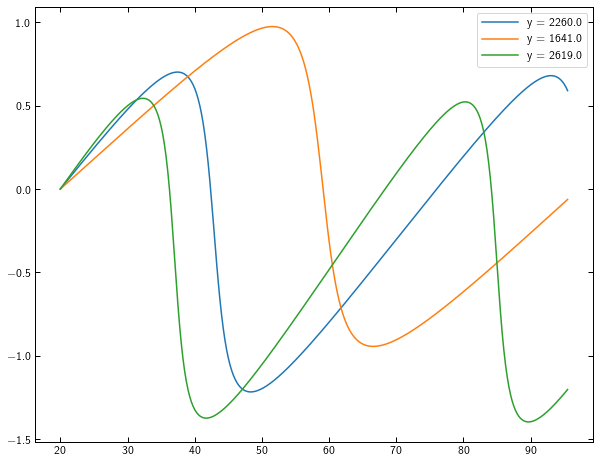

In [367]:
plt.figure(figsize=(10, 8))
for i in range(len(y_arr)):
    plt.plot(freq_arr, (bigdip_analysis_def_2(max_tc_2[i], phi_c_temp_2[i], y_arr[0], ML_arr_2[i])), label = f'y = {ML_arr_2[i] / solar_mass}')
plt.legend()

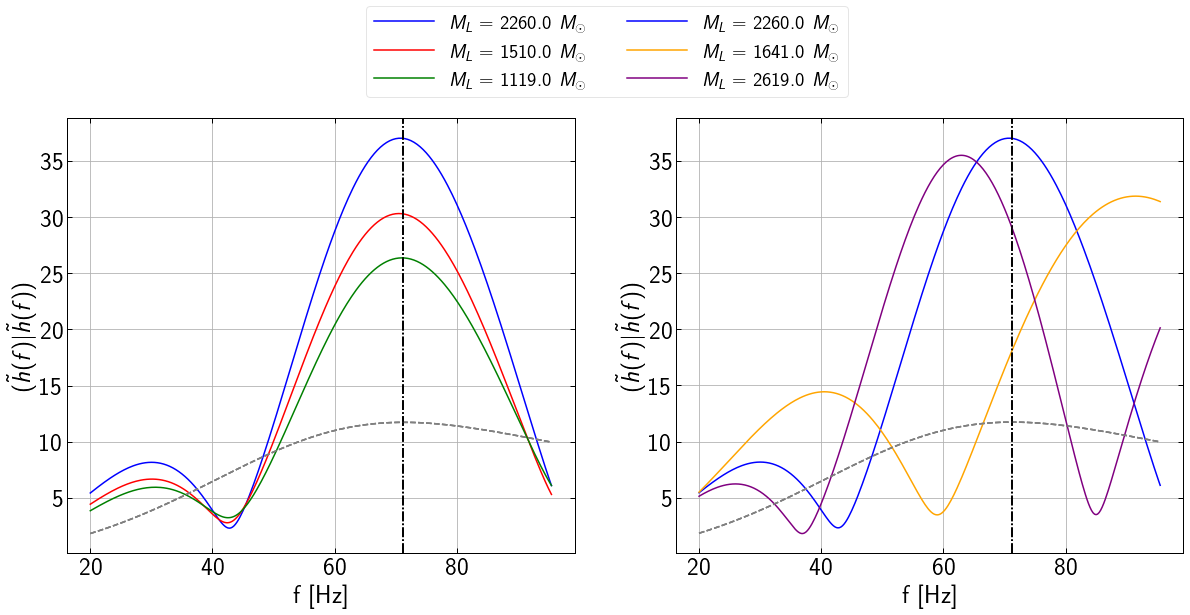

In [383]:
import matplotlib
matplotlib.rc('font', size=25)


fig, axs = plt.subplots(1, 2, figsize = (20, 8))

#color = ['blue', 'green', 'purple']
integrand = 4 * (np.abs(hf) ** 2 / psd_analytical)
max_freq = freq_arr[np.argmax(integrand)]

for i in range(len(ML_arr)):
    hf_lensed = hf * amp_fact_pm_wo(y_arr[i], ML_arr[i])
    integrand_lensed = 4 * (np.abs(np.conjugate(hf_lensed) * hf) / psd_analytical)
    axs[0].plot(freq_arr, integrand_lensed, label = rf'$M_L$ = {ML_arr[i] / solar_mass:.1f} $M_\odot$',c = color_amp_1[i])
    axs[0].plot(freq_arr, integrand, ls = '--', color = 'gray')
    axs[0].grid()
    axs[0].axvline(max_freq, ls = '-.', c = 'black')
    axs[0].tick_params(axis='both', which='major', labelsize=25)
    axs[0].set_xlabel('f [Hz]', fontsize = 25)
    axs[0].set_ylabel(r'$(\tilde{h}(f)|\tilde{h}(f))$', fontsize = 25)
    
    
for i in range(len(ML_arr_2)):
    hf_lensed = hf * amp_fact_pm_wo(y_arr[0], ML_arr_2[i])
    integrand_lensed = 4 * (np.abs(np.conjugate(hf_lensed) * hf )/ psd_analytical)
    axs[1].plot(freq_arr, integrand_lensed, label = rf'$M_L$ = {ML_arr_2[i] / solar_mass:.1f} $M_\odot$', c = color_amp_2[i])
    axs[1].plot(freq_arr, integrand, ls = '--', color = 'gray')
    axs[1].grid()
    axs[1].axvline(max_freq, ls = '-.', c = 'black')
    axs[1].tick_params(axis='both', which='major', labelsize=25)
    axs[1].set_xlabel('f [Hz]', fontsize = 25)
    axs[1].set_ylabel(r'$(\tilde{h}(f)|\tilde{h}(f))$', fontsize = 25)
    
fig.legend(ncol=2,loc='lower center',bbox_to_anchor=(0.5,.9),fontsize=20,framealpha=0.5)
# plt.savefig(plotdirName + 'big_dip_integrand.pdf', dpi = 500, bbox_inches = 'tight')

## Compare SIS and PM 

In [43]:
def invert_lensparam_to_sis(I, td):
    y = (1 - I) / (1 + I)
    ML = td / (8 * y)  
    return y, ML

In [44]:
y_sis_invert, ML_sis_invert = invert_lensparam_to_sis(I_mesh_pm, td_mesh_pm)

In [45]:
df = pd.DataFrame(columns = ('y_sis_invert', 'ML_sis_invert'))
df['y_sis_invert'] = y_sis_invert.ravel()
df['ML_sis_invert'] = ML_sis_invert.ravel()

df.to_csv('inverted_lensparam_to_sis.csv', index = False)

In [46]:
data_sis_compare = pd.read_csv('/Users/saifali/Desktop/gwlensing/data/pycbc_match_sis_vs_pm.csv', header = None, converters = {1: eval})
data_sis_compare['y_sis_compare'] = np.array([data_sis_compare[1][i][0] for i in range(len(data_sis_compare))])
data_sis_compare['ML_sis_comapre'] = np.array([data_sis_compare[1][i][1] for i in range(len(data_sis_compare))])
data_sis_compare['match_sis_compare'] = np.array([data_sis_compare[1][i][2] for i in range(len(data_sis_compare))])
data_sis_compare = data_sis_compare.sort_values(by = 0)

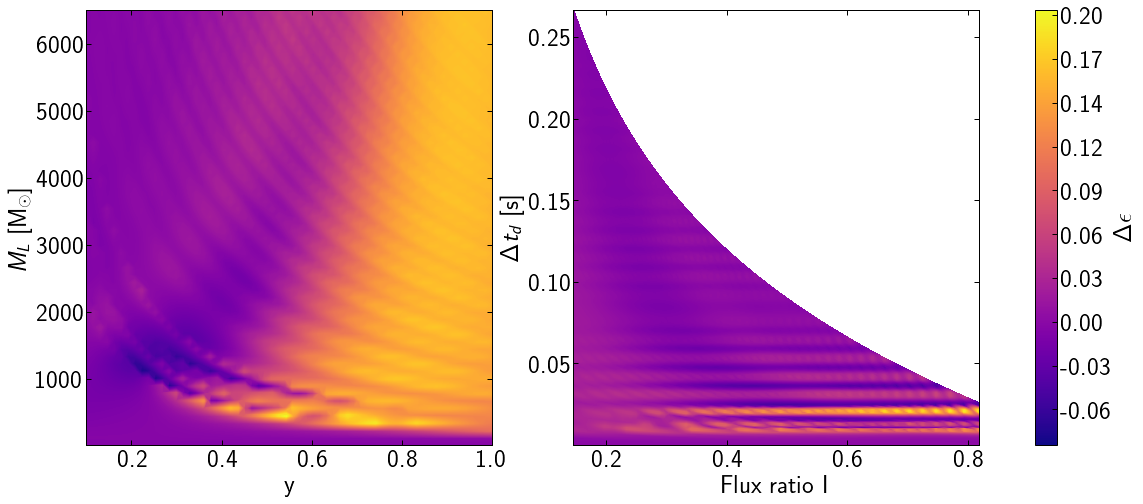

In [47]:
mismatch_sis_compare = 1 - data_sis_compare['match_sis_compare']
mismatch_diff_new_param = (mismatch_mesh_pm - np.array(mismatch_sis_compare).reshape(dat_pts, dat_pts))
mismatch_diff_old_param = (mismatch_mesh_pm - mismatch_mesh_sis)

fig, ax = plt.subplots(1, 2, figsize = (20, 8))
cp2 = ax[1].contourf(I_mesh_pm, td_mesh_pm, mismatch_diff_new_param, levels = 1000, cmap = 'plasma')
cp1 = ax[0].contourf(y_mesh, ML_mesh / solar_mass, mismatch_diff_old_param, levels = 1000, cmap = 'plasma')

ax[0].set_xlabel('y', fontsize = 25)
ax[0].set_ylabel(r'$M_L$ $[\mathrm{M}_\odot]$', fontsize = 25)
ax[0].tick_params(axis='both', which='both', direction='in', labelsize=25)

ax[1].set_xlabel('Flux ratio I', fontsize = 25)
ax[1].set_ylabel(r'$\Delta t_d$ [s]', fontsize = 25)
ax[1].tick_params(axis='both', which='both', direction='in', labelsize=25)


cbar = fig.colorbar(cp2, ax=ax.ravel().tolist())
cbar.set_label(r'$\Delta \epsilon$', fontsize=25)
cbar.ax.tick_params(direction='in',labelsize=25)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))

# for c in cp1.collections:
#     c.set_edgecolor("face")
# for c in cp2.collections:
#     c.set_edgecolor("face")

# plt.savefig(plotdirName + 'contour_plot_compare_lensparam.pdf', dpi = 500, bbox_inches = 'tight')